## **Using a Convolutional Neural Network to Identify Cube Rotations.**

In this notebook, I will be using images which I have generated using my Shape3D.py and GenerateData.py images, found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

I will be using TensorFlow2 and Keras to create a Sequential model which will be trained using the cube images, and then more images will be tested to see if the model can correctly identify their rotations.

The tutorial I followed can be found at https://www.tensorflow.org/tutorials/images/classification.

# Importing the relevant libraries.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Creating the dataset.

Retrieving images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

folder_name = "Cubes"
direc = os.path.join("/content/drive/MyDrive/Nanoparticles/", folder_name)
img_size = (128, 128) # Image dimensions

Mounted at /content/drive


First, the images to be used for training must be assigned to the training subset. I will be using 80% to train, and 20% to validate. The images are loaded in using PIL and converted to NumPy arrays.

In [ ]:
def load_imgs_from_path(folder_path):
  labels = []
  imgs = []
  
  for rotation in os.listdir(folder_path):
    rotation_path = os.path.join(folder_path, rotation)
    label = json.loads(rotation)
    for image_name in os.listdir(rotation_path):
      labels.append(label)
      img = PIL.Image.open(os.path.join(rotation_path, image_name))#.convert('L')
      img_array = np.array(img)
      imgs.append(img_array)

  return np.array(imgs), np.array(labels)

In [ ]:
training_path = os.path.join(direc, "Train")
testing_path = os.path.join(direc, "Test")

train_imgs, train_labels = load_imgs_from_path(training_path)
test_imgs, test_labels = load_imgs_from_path(testing_path)

The arrays will be shuffled to randomise the order for the machine learning.

In [ ]:
def shuffle(imgs_array, labels_array):
  order = np.arange(imgs_array.shape[0])
  np.random.shuffle(order)
  return imgs_array[order], labels_array[order]

In [ ]:
train_imgs, train_labels = shuffle(train_imgs, train_labels)
test_imgs, test_labels = shuffle(test_imgs, test_labels)

Using data augmentation adds some more variety to the training data, thus resulting in a higher accuracy.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(*img_size,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Creating the model.

In [ ]:
# TODO: Possibly change this?
def get_model(n_inputs, n_outputs):
  model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(n_outputs, kernel_initializer='he_uniform')
  ])

  return model

Creating and compiling the model.

In [ ]:
model = get_model(train_imgs.shape[1], train_labels.shape[1])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 128, 128, 1)       0         
                                                                 
 rescaling_16 (Rescaling)    (None, 128, 128, 1)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                

# Training the model.

In [ ]:
epochs = 50
batch_size = 64

# TODO: Change this!
history = model.fit(
  x=train_imgs,
  y=train_labels,
  batch_size=batch_size,
  epochs=epochs,
  validation_split=0.2
)

Epoch 1/50


InvalidArgumentError: ignored

Visualizing the training results.

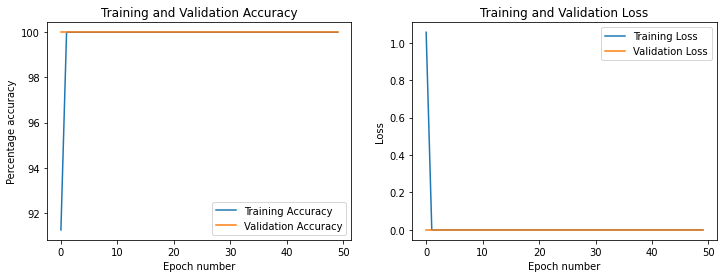

In [ ]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc * 100, label='Training Accuracy')
plt.plot(epochs_range, val_acc * 100, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch number")
plt.ylabel("Percentage accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.show()

# Predicting an image.

In [ ]:
# TODO: Change this! and everything after

def predict_image(file_path, prediction_dict):
  img_path = os.path.join(data_dir, file_path)

  img = tf.keras.utils.load_img(
      img_path, target_size=img_size, color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  prediction = class_names[np.argmax(score)]

  prediction = json.loads(prediction)

  rotation = np.array(prediction).reshape((2, 3)).T
  v1 = rotation[:, 0]
  v2 = rotation[:, 1]

  e1 = v1 / np.abs(v1)
  
  u2 = v2 - ((e1 * v2) * e1)
  e2 = u2 / np.abs(u2)

  e3 = np.cross(e1, e2) 
  
  R = np.vstack((e1, e2, e3)).T
  print("Predicted: %s" % R)

#   print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(prediction, 100 * np.max(score))
# )

  # temp_names = file_path.split("/")[-1].split() # Splits file name of image up
  # # Format: Shape W RX RY
  # actual_shape, width, actual_rx = temp_names[0], temp_names[1], temp_names[2]

  # predicted = class_names[np.argmax(score)]
  # confidence = 100 * np.max(score)

  # predicted_shape = predicted.split()[0]
  # predicted_rx = predicted.split()[1]

  # actual = "%s %s" % (actual_shape, actual_rx)

  # print("\t%s \t| \t%s" % (actual, predicted))

  # # Refactor dictionary to take into account shape as well as rotation
  # if actual==predicted:
  #   prediction_dict[actual + " CORRECT"] += 1
  # else:
  #   prediction_dict[actual + " INCORRECT"] += 1
  #   prediction_dict[actual + " DIF"] += abs(int(actual_rx[2:]) - int(predicted_rx[2:]))
  # prediction_dict[actual + " CONFIDENCE"] += confidence

  # return prediction_dict

In [ ]:
prediction_files = os.path.join(direc, "Test", "Train")

predict_dictionary = {}

for i in class_names:
  predict_dictionary[i + " CORRECT"] = 0
  predict_dictionary[i + " INCORRECT"] = 0
  predict_dictionary[i + " CONFIDENCE"] = 0
  predict_dictionary[i + " DIF"] = 0

for folder in os.listdir(prediction_files):
  for file in os.listdir(os.path.join(prediction_files, folder)):
    file_path = os.path.join(prediction_files, folder, file)
    #predict_dictionary = predict_image(file_path, predict_dictionary)
    predict_image(file_path, predict_dictionary)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


ValueError: ignored

In [ ]:
correct = []
incorrect = []
confidence = []
dif = []

for i in class_names:
  temp_dif = predict_dictionary[i + " DIF"]
  temp_inc = predict_dictionary[i + " INCORRECT"]
  temp_cor = predict_dictionary[i + " CORRECT"]

  total = temp_cor + temp_inc

  correct.append(100 * temp_cor / total)
  incorrect.append(100 * temp_inc / total)
  dif.append(temp_dif / total)
  confidence.append(predict_dictionary[i + " CONFIDENCE"] / total)

Sorting the results in order of increasing angle.

In [ ]:
order = []

for i in class_names:
  order.append(int(i.split()[-1][2:]))

order = list(np.argsort(order))
order = order[::2] + order[1::2]
ordered_names = np.array(class_names)[order]
ordered_correct = np.array(correct)[order]
ordered_incorrect = np.array(incorrect)[order]
ordered_confidence = np.array(confidence)[order]
ordered_dif = np.array(dif)[order]

Visualising how accurately the model predicts rotations.

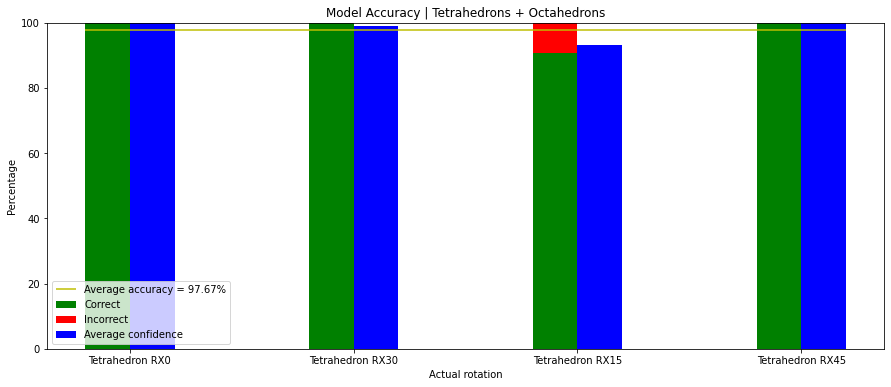

In [ ]:
bar_width = 0.2 
x = np.arange(len(ordered_names))

plt.figure(figsize=(15, 6))
plt.subplot(111)
plt.bar(x-bar_width/2, ordered_correct, bar_width,
        color="g", label='Correct')
plt.bar(x-bar_width/2, ordered_incorrect, bar_width, bottom=ordered_correct,
       color="r", label='Incorrect')
plt.bar(x+bar_width/2, ordered_confidence, bar_width,
        color="b", label="Average confidence")
plt.hlines(np.mean(ordered_correct), x[0]-bar_width, x[-1]+bar_width,
           color="y", label = "Average accuracy = %s%%" % round(np.mean(ordered_correct), 2))
plt.title("Model Accuracy | %s" % "Tetrahedrons + Octahedrons")#folder_name)
plt.xlabel("Actual rotation")
plt.xticks(x, ordered_names)
plt.ylabel("Percentage")
plt.legend(loc='lower left')
plt.show()

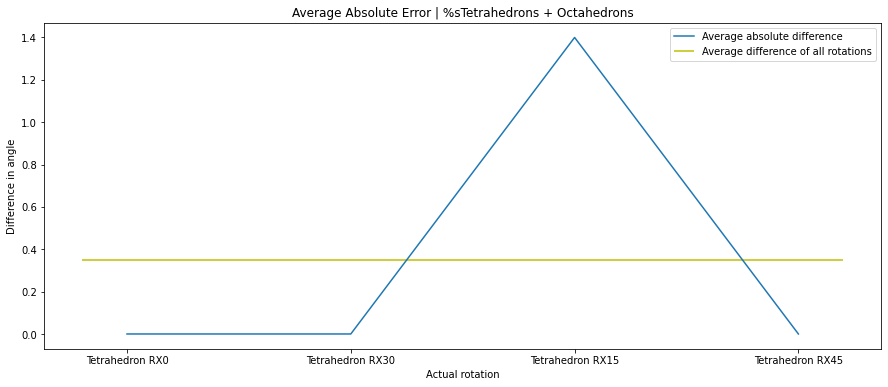

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(111)
plt.plot(x, ordered_dif, label="Average absolute difference")
plt.hlines(np.mean(ordered_dif), x[0]-bar_width, x[-1]+bar_width,
           color="y", label = "Average difference of all rotations")
plt.xlabel("Actual rotation")
plt.xticks(x, ordered_names)
plt.ylabel("Difference in angle")
plt.legend(loc="best")
plt.title("Average Absolute Error | %s" "Tetrahedrons + Octahedrons")#folder_name)
plt.show()